In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("Is PyTorch available?:", torch.cuda.is_available() or torch.backends.mps.is_available())

PyTorch version: 2.2.2
Is PyTorch available?: True


In [2]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple GPU
    print("MPS (Apple GPU) is available!")
else:
    device = torch.device("cpu")  # Default to CPU
    print("Using CPU")

MPS (Apple GPU) is available!


# Model 1: unitary/unbiased-toxic-roberta
You need transformers, and torch

In [3]:
import re
import pandas as pd
from transformers import pipeline

# Load Jigsaw Toxic RoBERTa model
model_name = "unitary/unbiased-toxic-roberta"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load the debate transcript from a .txt file
with open("debate_2020.txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speaker names and their statements
pattern = r"([A-Z]+): (.+)"

# Find all matches
matches = re.findall(pattern, debate_text)

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Speaker", "Statement"])

# Apply toxicity model to each statement
df["Hostility_Score"] = df["Statement"].apply(lambda x: toxicity_pipeline(x)[0]["score"])

/opt/anaconda3/envs/newspring/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In [ ]:
# Display first 10 rows of the DataFrame
df.head(10)  # Text-based output


,Speaker,Statement,Hostility_Score
0,WELKER,A very good evening to both of you. This debat...,0.000343
1,TRUMP,"So, as you know, more 2.2 million people, mode...",0.002341
2,WELKER,"OK, former Vice President Biden, to you, how w...",0.000404
3,BIDEN,"220,000 Americans dead. If you hear nothing el...",0.001068
4,WELKER,"President Trump, I'd like to follow up with yo...",0.000421
5,TRUMP,It is not a guarantee but it will be by the en...,0.000336
6,WELKER,Can you tell us what companies?,0.000448
7,TRUMP,Johnson and Johnson is doing very well. Modern...,0.000366
8,WELKER,"Let me follow up with you, and because this is...",0.000356
9,TRUMP,"No, I think my timeline is going to be more ac...",0.000401


In [7]:
# Group by Speaker and calculate the mean hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display the results
print(avg_hostility)

Speaker
BIDEN     0.075330
TRUMP     0.090486
WELKER    0.053226
Name: Hostility_Score, dtype: float64


## Sama analysis but different tokenization

In [10]:
import re
import pandas as pd
from transformers import pipeline

# Load Jigsaw Toxic RoBERTa model
model_name = "unitary/unbiased-toxic-roberta"
# model_name = "GroNLP/hateBERT"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load the debate transcript from a .txt file
with open("debate_2020.txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speakers and their statements
pattern = r"([A-Z]+): (.+)"
matches = re.findall(pattern, debate_text)

# Function to split text into sentences using regex
def split_into_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text)  # Splits sentences based on punctuation

# Convert to a list of (Speaker, Sentence) pairs
sentences = []
for speaker, statement in matches:
    for sentence in split_into_sentences(statement):
        sentences.append((speaker.lower(), sentence.lower().strip()))  # Convert to lowercase

# Convert to DataFrame
df = pd.DataFrame(sentences, columns=["Speaker", "Statement"])

# **Fix 1: Remove empty statements**
df = df[df["Statement"].str.strip() != ""]

# **Fix 2: Use Batch Processing (Faster & More Stable)**
batch_size = 8
statements_list = df["Statement"].tolist()
hostility_scores = toxicity_pipeline(statements_list, batch_size=batch_size, truncation=True, max_length=512)

# Assign scores to DataFrame
df["Hostility_Score"] = [result["score"] for result in hostility_scores]

Device set to use mps:0


In [11]:
# Display results
from IPython.display import display
display(df.head(10))

,Speaker,Statement,Hostility_Score
0,welker,a very good evening to both of you.,0.000491
1,welker,this debate will cover six major topics.,0.000416
2,welker,"at the beginning of each section, each candida...",0.000374
3,welker,the debate commission will then turn on their ...,0.000370
4,welker,"after that, both microphones will remain on, b...",0.000365
5,welker,the goal is for you to hear each other and for...,0.000465
6,welker,"and so with that, if you're ready, let's start.",0.000500
7,trump,"so, as you know, more 2.2 million people, mode...",0.207249
8,trump,we closed up the greatest economy in the world...,0.060030
9,trump,it's a worldwide pandemic.,0.106749


In [9]:
# Group by Speaker and calculate the mean hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display the results
print(avg_hostility)

Speaker
biden     0.612428
trump     0.613642
welker    0.604616
Name: Hostility_Score, dtype: float64


# Model 2: HateBERT
Trained on data from banned Reddit communities

In [9]:
import re
import pandas as pd
from transformers import pipeline

# Load HateBERT model
model_name = "GroNLP/hateBERT"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load debate transcript
with open("debate_2020.txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speakers and their statements
pattern = r"([A-Z]+): (.+)"
matches = re.findall(pattern, debate_text)

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Speaker", "Statement"])

# Apply HateBERT to detect hostility
df["Hostility_Score"] = df["Statement"].apply(lambda x: toxicity_pipeline(x)[0]["score"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


In [10]:
# Display first few results
from IPython.display import display
display(df.head(10))

,Speaker,Statement,Hostility_Score
0,WELKER,A very good evening to both of you. This debat...,0.589269
1,TRUMP,"So, as you know, more 2.2 million people, mode...",0.612701
2,WELKER,"OK, former Vice President Biden, to you, how w...",0.590989
3,BIDEN,"220,000 Americans dead. If you hear nothing el...",0.603801
4,WELKER,"President Trump, I'd like to follow up with yo...",0.604721
5,TRUMP,It is not a guarantee but it will be by the en...,0.555635
6,WELKER,Can you tell us what companies?,0.580086
7,TRUMP,Johnson and Johnson is doing very well. Modern...,0.557236
8,WELKER,"Let me follow up with you, and because this is...",0.602819
9,TRUMP,"No, I think my timeline is going to be more ac...",0.584964


calculating average hostility per speaker

In [11]:
# Group by Speaker and calculate average hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display results
print(avg_hostility)

Speaker
BIDEN     0.590998
TRUMP     0.591169
WELKER    0.593719
Name: Hostility_Score, dtype: float64


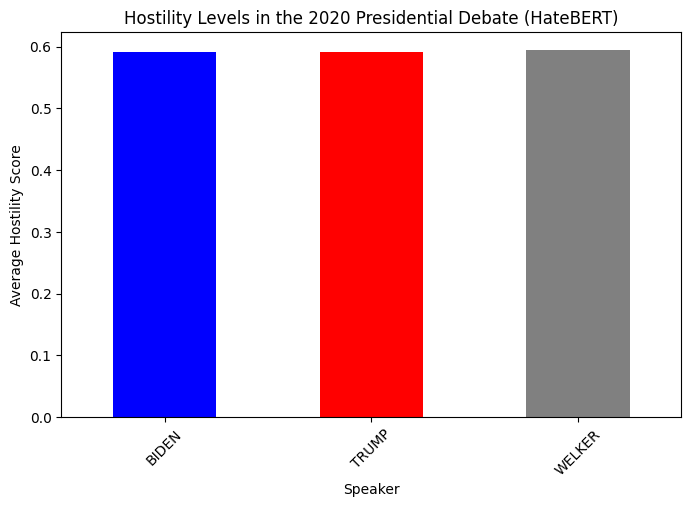

In [14]:
import matplotlib.pyplot as plt

# Plot hostility levels per speaker
plt.figure(figsize=(8, 5))
avg_hostility.sort_values().plot(kind="bar", color=["blue", "red", "gray"])

# Customize plot
plt.xlabel("Speaker")
plt.ylabel("Average Hostility Score")
plt.title("Hostility Levels in the 2020 Presidential Debate (HateBERT)")
plt.xticks(rotation=45)
plt.show()

# 1960 Debate

In [18]:
# Load HateBERT model
model_name = "GroNLP/hateBERT"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load debate transcript
with open("debate_1960.txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speakers and their statements
pattern = r"([A-Z]+): (.+)"
matches = re.findall(pattern, debate_text)

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Speaker", "Statement"])

# Apply HateBERT to detect hostility
df["Hostility_Score"] = df["Statement"].apply(
    lambda x: toxicity_pipeline(x, truncation=True, max_length=512)[0]["score"]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


In [19]:
# Display first few results
from IPython.display import display
display(df.head(10))

,Speaker,Statement,Hostility_Score
0,NIVEN,"Mr. Vice President, Senator Kennedy said last ...",0.542889
1,NIXON,"Well first of all, I don't agree with Senator ...",0.530614
2,GEE,"Senator Kennedy, would you care to comment?",0.529398
3,KENNEDY,In the first place I've never suggested that C...,0.531645
4,GEE,"Mr. Morgan, with a question for Senator Kennedy.",0.533749
5,MORGAN,"Senator, last May, in Oregon, you discussed th...",0.519977
6,KENNEDY,"Mr. Morgan, I suggested that if the United Sta...",0.522550
7,GEE,Mr. Vice President.,0.535864
8,NIXON,I think Kenne- Senator Kennedy is wrong on thr...,0.504109
9,GEE,Mr. Spivak with a question for Vice President ...,0.530240


In [20]:
# Group by Speaker and calculate average hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display results
print(avg_hostility)

Speaker
GEE        0.537711
KENNEDY    0.521706
LEVY       0.506102
MORGAN     0.517299
NIVEN      0.522135
NIXON      0.519576
SPIVAK     0.520748
Name: Hostility_Score, dtype: float64


# 2000 Debate

In [21]:
# Load HateBERT model
model_name = "GroNLP/hateBERT"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load debate transcript
with open("debate_2000.txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speakers and their statements
pattern = r"([A-Z]+): (.+)"
matches = re.findall(pattern, debate_text)

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Speaker", "Statement"])

# Apply HateBERT to detect hostility
df["Hostility_Score"] = df["Statement"].apply(
    lambda x: toxicity_pipeline(x, truncation=True, max_length=512)[0]["score"]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


In [22]:
# Display first few results
from IPython.display import display
display(df.head(10))

,Speaker,Statement,Hostility_Score
0,MODERATOR,Good evening from the Field House at Washingto...,0.508286
1,GORE,I'm glad you clarified that.,0.504353
2,MODERATOR,"Now, let's go to the first question. Of over t...",0.501875
3,AUDIENCE,How do you feel about HMOs and insurance compa...,0.511723
4,GORE,"Mr. Hankins, I don't feel good about it, and I...",0.513021
5,MODERATOR,"Two minutes response, Governor Bush.",0.500678
6,BUSH,"I, too, want to extend my prayers and blessing...",0.518265
7,MODERATOR,"Governor, time is up, sir.",0.544366
8,GORE,"Jim, we have a direct disagreement on this.",0.509585
9,MODERATOR,"Just a minute, Mr. Vice President. I want to -...",0.510310


In [23]:
# Group by Speaker and calculate average hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display results
print(avg_hostility)

Speaker
AUDIENCE     0.532857
BUSH         0.522929
GORE         0.524430
MODERATOR    0.518136
Name: Hostility_Score, dtype: float64


# 2024 Debate (Trump and Biden)

In [26]:
# Load HateBERT model
model_name = "GroNLP/hateBERT"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Load debate transcript
with open("Debate 2024 (Biden-Trump).txt", "r", encoding="utf-8") as f:
    debate_text = f.read()

# Regex pattern to extract speakers and their statements
pattern = r"([A-Z]+): (.+)"
matches = re.findall(pattern, debate_text)

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Speaker", "Statement"])

# Apply HateBERT to detect hostility
df["Hostility_Score"] = df["Statement"].apply(
    lambda x: toxicity_pipeline(x, truncation=True, max_length=512)[0]["score"]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


In [27]:
# Display first few results
from IPython.display import display
display(df.head(10))

,Speaker,Statement,Hostility_Score
0,TAPPER,"We're live from Georgia, a key battleground st...",0.514541
1,BASH,This debate is being produced by CNN and it's ...,0.554406
2,TAPPER,"I'm Jake Tapper, anchor of CNN's ""THE LEAD"" an...",0.555700
3,BASH,"When it's time for our candidate to speak, his...",0.505097
4,TAPPER,"Now, please welcome the 46th of the United Sta...",0.534843
5,BIDEN,"Folks, how are you? Good to be here. Thank you.",0.510819
6,TAPPER,And please welcome the 45th president of the U...,0.538920
7,BIDEN,We've got to take a look at what I was left wh...,0.542055
8,TAPPER,Thank you.,0.504233
9,TRUMP,We had the greatest economy in the history of ...,0.549413


In [28]:
# Group by Speaker and calculate average hostility score
avg_hostility = df.groupby("Speaker")["Hostility_Score"].mean()

# Display results
print(avg_hostility)

Speaker
BASH      0.534971
BIDEN     0.531242
TAPPER    0.533231
TRUMP     0.532989
Name: Hostility_Score, dtype: float64
